In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
pl_rank = pd.read_csv('PL_ranks.csv')

In [3]:
unique_bookmakers = [
    #"1XB",  # From 1XBH, 1XBD, 1XBA
    "B365", # From B365H, B365D, B365A
    "BF",   # From BFH, BFD, BFA
    "BFD",  # From BFDH, BFDD, BFDA (This is specific to Betfred based on your list)
    "BMGM", # From BMGMH, BMGMD, BMGMA
    "BV",   # From BVH, BVD, BVA
    "BS",   # From BSH, BSD, BSA
    "BW",   # From BWH, BWD, BWA
    "CL",   # From CLH, CLD, CLA
    "GB",   # From GBH, GBD, GBA
    "IW",   # From IWH, IWD, IWA
    "LB",   # From LBH, LBD, LBA
    "PSH/PH", # From PSH and PH (Pinnacle)
    "PSD/PD", # From PSD and PD (Pinnacle)
    "PSA/PA", # From PSA and PA (Pinnacle)
    "SO",   # From SOH, SOD, SOA
    "SB",   # From SBH, SBD, SBA
    "SJ",   # From SJH, SJD, SJA
    "SY",   # From SYH, SYD, SYA
    "VC",   # From VCH, VCD, VCA (VC Bet)
    "WH"    # From WHH, WHD, WHA
]


In [14]:
premier_league_promoted_teams = {
    "2010/2011": ["Newcastle United", "West Bromwich Albion", "Blackpool"],
    "2011/2012": ["Queens Park Rangers", "Norwich City", "Swansea City"],
    "2012/2013": ["Reading", "Southampton", "West Ham United"],
    "2013/2014": ["Cardiff City", "Hull City", "Crystal Palace"],
    "2014/2015": ["Leicester City", "Burnley", "Queens Park Rangers"],
    "2015/2016": ["AFC Bournemouth", "Watford", "Norwich City"],
    "2016/2017": ["Burnley", "Middlesbrough", "Hull City"],
    "2017/2018": ["Newcastle United", "Brighton & Hove Albion", "Huddersfield Town"],
    "2018/2019": ["Wolverhampton Wanderers", "Cardiff City", "Fulham"],
    "2019/2020": ["Norwich City", "Sheffield United", "Aston Villa"],
    "2020/2021": ["Leeds United", "West Bromwich Albion", "Fulham"],
    "2021/2022": ["Norwich City", "Watford", "Brentford"],
    "2022/2023": ["Fulham", "AFC Bournemouth", "Nottingham Forest"],
    "2023/2024": ["Burnley", "Sheffield United", "Luton Town"],
    "2024/2025": ["Leicester City", "Ipswich Town", "Southampton"]
}

# Filter function
def is_rookie(row):
    return row['Team'] in premier_league_promoted_teams.get(row['Season'], [])

In [5]:
sns.set_theme(style="whitegrid")

def plot(series, title, x, y, hue_series=None, rotate_xticks=True, color="steelblue"):
    """
    Plots a bar chart from a Pandas Series with optional hue coloring.

    Parameters:
        series (pd.Series): The data to plot. Index = x-axis, values = y-axis.
        title (str): Title of the chart.
        x (str): X-axis label.
        y (str): Y-axis label.
        hue_series (pd.Series): Optional. Series aligned with 'series' that defines bar colors/groups.
        rotate_xticks (bool): Rotate x-axis labels if True.
        color (str): Default bar color if no hue_series is provided.
    """
    plt.figure(figsize=(10, 6))

    if hue_series is not None:
        # Merge into a DataFrame for seaborn compatibility
        df = pd.DataFrame({
            x: series.index,
            y: series.values,
            "Hue": hue_series.reindex(series.index).values
        })
        sns.barplot(data=df, x=x, y=y, hue="Hue")
        plt.legend(title=hue_series.name or "Group", loc='upper right')
    else:
        series.plot.bar(color=color, edgecolor='black')

    plt.title(title, fontsize=14, pad=12)
    plt.xlabel(x, fontsize=12)
    plt.ylabel(y, fontsize=12)

    if rotate_xticks:
        plt.xticks(rotation=45, ha='right')

    plt.axhline(0, color='black', linewidth=0.8)
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [7]:
def calculate_anti_team_betting_profits(file_path, bookie, ranks_df):
    """
    Calculates betting profits for betting on a team's loss every game,
    and includes their season ranking from the ranks_df.

    Parameters:
        file_paths (list of str): Paths to CSV files with PL match data.
        bookie (str): Bookmaker prefix (e.g., 'B365').
        ranks_df (pd.DataFrame): DataFrame with 'Season', 'Team', 'Rank', etc.

    Returns:
        None
    """
    
    # Mapping from abbreviated team names to full names used in ranks_df
    team_name_map = {
        "Man United": "Manchester United",
        "Man City": "Manchester City",
        "Tottenham": "Tottenham Hotspur",
        "Nott'm Forest": "Nottingham Forest",
        "West Brom": "West Bromwich Albion",
        "Newcastle": "Newcastle United",
        "Wolves": "Wolverhampton Wanderers",
        "Sheffield Utd": "Sheffield United",
        "Brighton": "Brighton and Hove Albion",
        "Leeds": "Leeds United",
        "Norwich": "Norwich City",
        "Stoke": "Stoke City",
        "Swansea": "Swansea City",
        "Hull": "Hull City",
        "West Ham": "West Ham United",
        "Bournemouth": "AFC Bournemouth",
        "Birmingham": "Birmingham City",
        "Cardiff": "Cardiff City",
        "Huddersfield": "Huddersfield Town",
        "QPR": "Queens Park Rangers",
        "Blackburn": "Blackburn Rovers",
        "Wigan": "Wigan Athletic",
        "Bolton": "Bolton Wanderers",
        "Reading": "Reading",
        "Burnley": "Burnley",
        "Everton": "Everton",
        "Fulham": "Fulham",
        "Leicester": "Leicester City",
        "Liverpool": "Liverpool",
        "Southampton": "Southampton",
        "Arsenal": "Arsenal",
        "Chelsea": "Chelsea",
        "Crystal Palace": "Crystal Palace",
        "Aston Villa": "Aston Villa",
        "Brentford": "Brentford",
        "Luton": "Luton Town",
        "Watford": "Watford",
    }

    df = pd.read_csv(file_path)

    if not all(col in df.columns for col in [f"{bookie}H", f"{bookie}A"]):
        print(f"Missing odds columns for bookie {bookie} in {file_path}")
        return None

    try:
        assert isinstance(df[f'{bookie}A'].iloc[0], float)
    except AssertionError:
        print(f"Column '{bookie}A' in {file_path} is not of type float.")
        return None

    try:
        year_start = int(df.iloc[0]['Date'][-4:])
        season_str = f"{year_start}/{year_start + 1}"
        
    except:
        year_start = int(file_path.split('/')[-1].split('-')[0]) + 2000
        season_str = f"{year_start}/{year_start + 1}"

        # Convert the 'Date' column to datetime objects
        date_format = "%d/%m/%y"  # Specify the format of your date strings
        df['Date'] = pd.to_datetime(df['Date'], format=date_format)
        df['Date'] = df['Date'].dt.strftime("%m/%d/%Y")
    
    # Calculate profits given betting on a team's loss
    profits = {}
    for team in df['HomeTeam'].unique():
        df_team = df[(df['HomeTeam'] == team) | (df['AwayTeam'] == team)]
        profit = 0
        stake = 1

        for _, row in df_team.iterrows():
            if (row['FTR'] == 'H' and row['HomeTeam'] != team) or \
                (row['FTR'] == 'A' and row['AwayTeam'] != team):
                odds = row[f'{bookie}A'] if row['HomeTeam'] == team else row[f'{bookie}H']
                profit += (odds * stake - stake)
            else:
                profit -= stake

        profits[team] = profit

    # Build DataFrame
    profits_df = pd.DataFrame.from_dict(profits, orient='index', columns=['Profit'])
    profits_df.reset_index(inplace=True)
    profits_df.rename(columns={'index': 'Team'}, inplace=True)
    profits_df['Season'] = season_str

    # Standardize team names to match ranks_df
    profits_df['Team'] = profits_df['Team'].replace(team_name_map)

    # Merge
    merged_df = pd.merge(profits_df, ranks_df, on=['Season', 'Team'], how='left')

    merged_df.sort_values(by='Profit', ascending=False, inplace=True)

    return merged_df

B365


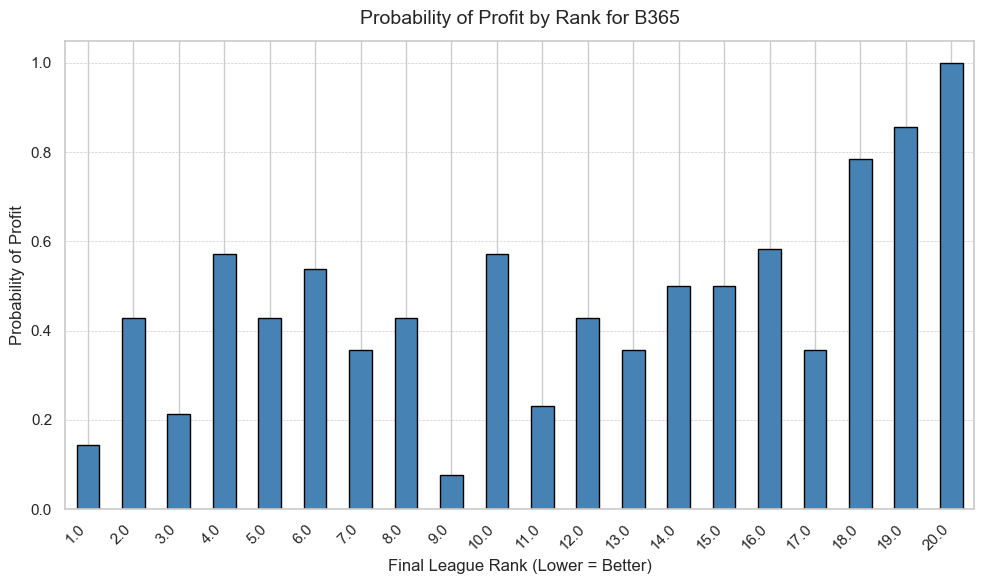

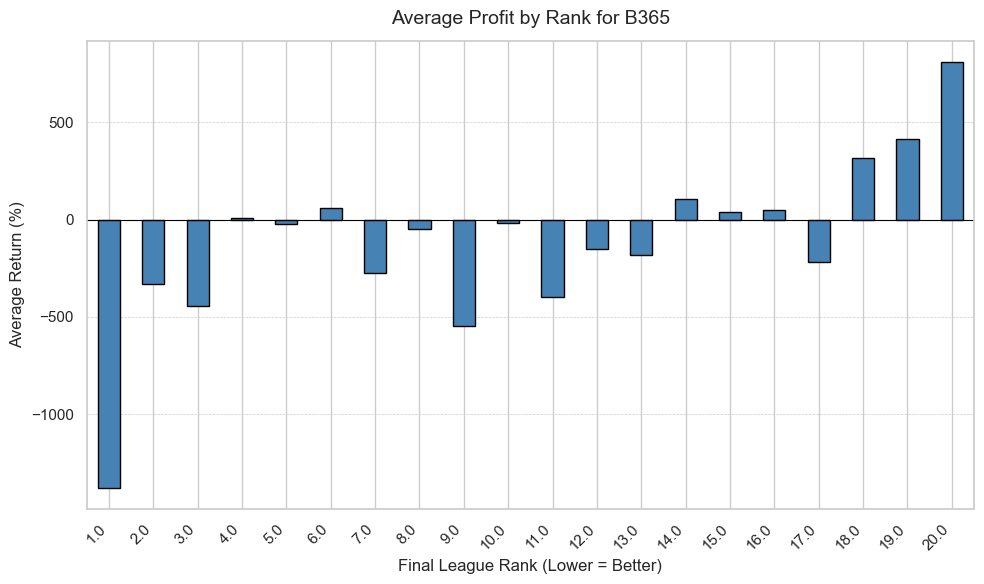

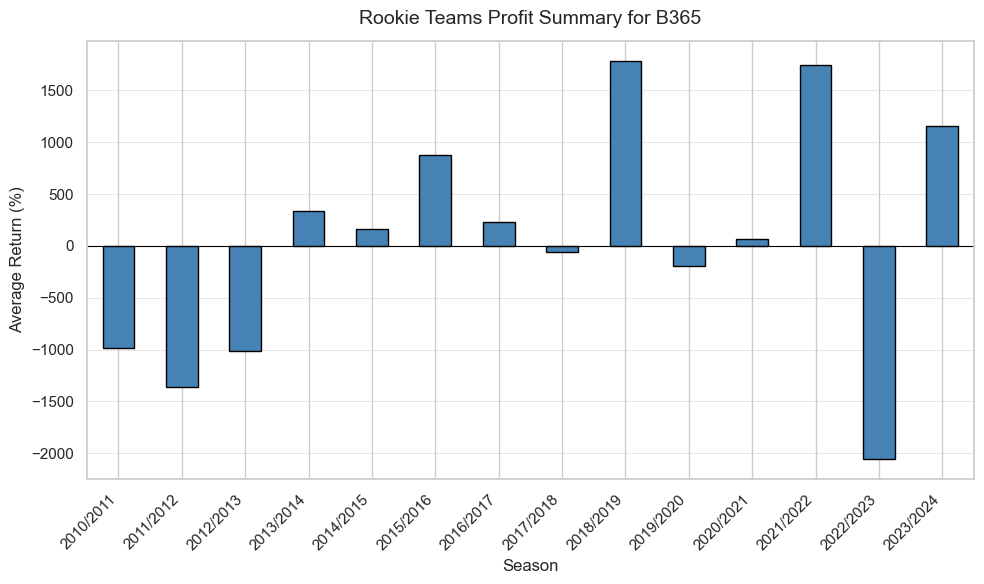

Average Rookie Teams Profit for B365: 49.57 %
Average Profit for B365 from relegating teams: 511.71 %
--------------------------------------------------

BF
Missing odds columns for bookie BF in PL_data/10-11.csv
Missing odds columns for bookie BF in PL_data/11-12.csv
Missing odds columns for bookie BF in PL_data/12-13.csv
Missing odds columns for bookie BF in PL_data/13-14.csv
Missing odds columns for bookie BF in PL_data/14-15.csv
Missing odds columns for bookie BF in PL_data/15-16.csv
Missing odds columns for bookie BF in PL_data/16-17.csv
Missing odds columns for bookie BF in PL_data/17-18.csv
Missing odds columns for bookie BF in PL_data/18-19.csv
Missing odds columns for bookie BF in PL_data/19-20.csv
Missing odds columns for bookie BF in PL_data/20-21.csv
Missing odds columns for bookie BF in PL_data/21-22.csv
Missing odds columns for bookie BF in PL_data/22-23.csv
Missing odds columns for bookie BF in PL_data/23-24.csv
BFD
Missing odds columns for bookie BFD in PL_data/10-11.cs

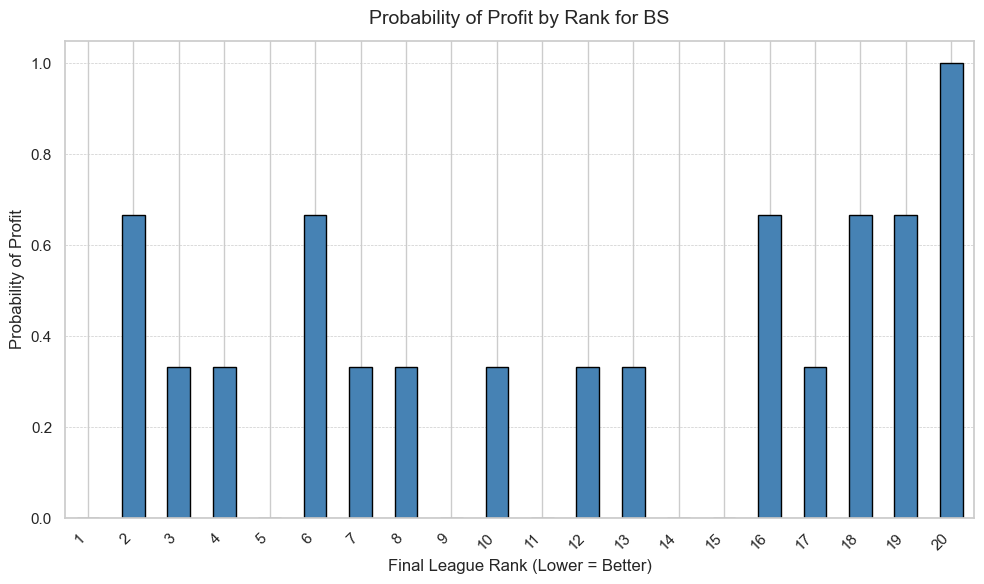

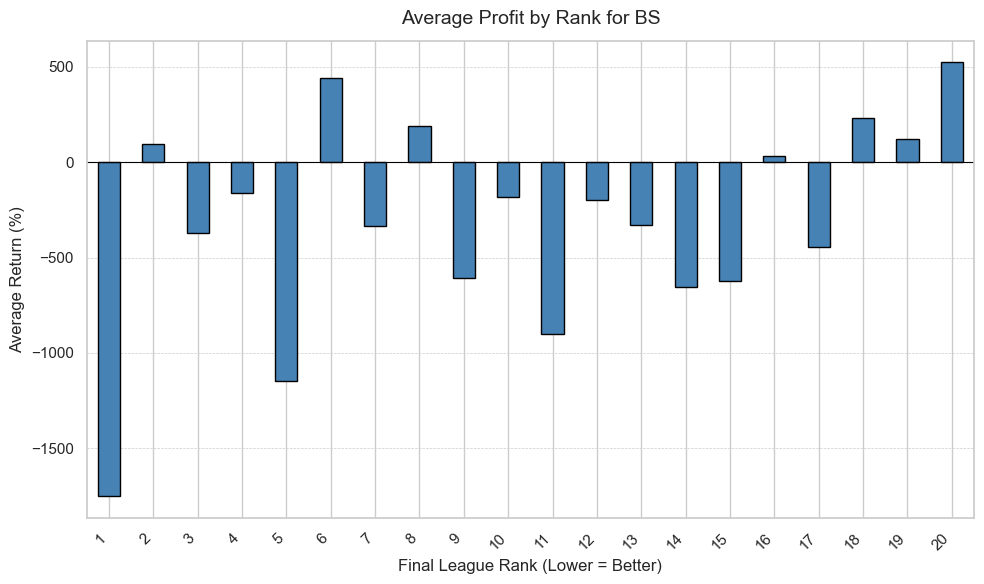

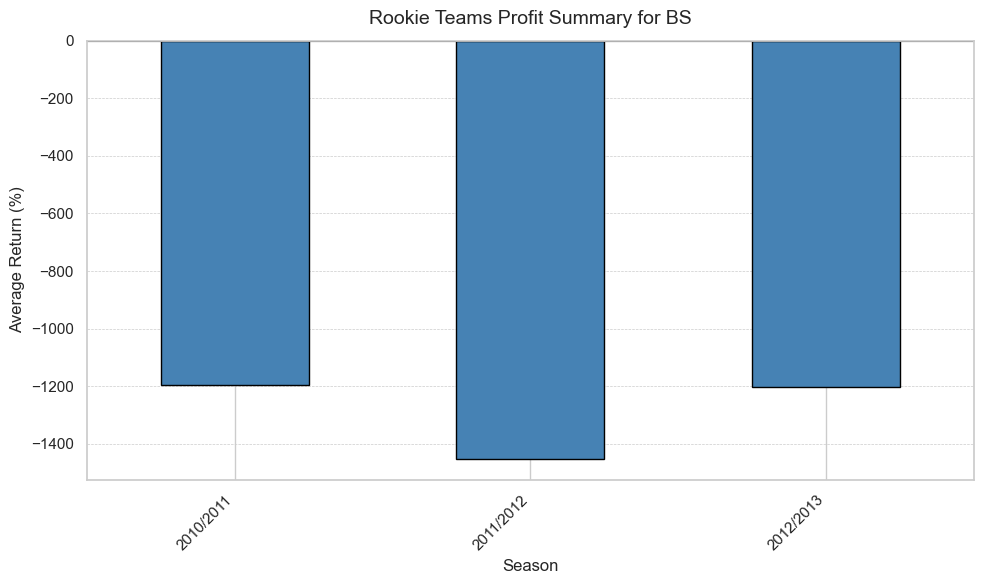

Average Rookie Teams Profit for BS: -1282.67 %
Average Profit for BS from relegating teams: 293.11 %
--------------------------------------------------

BW


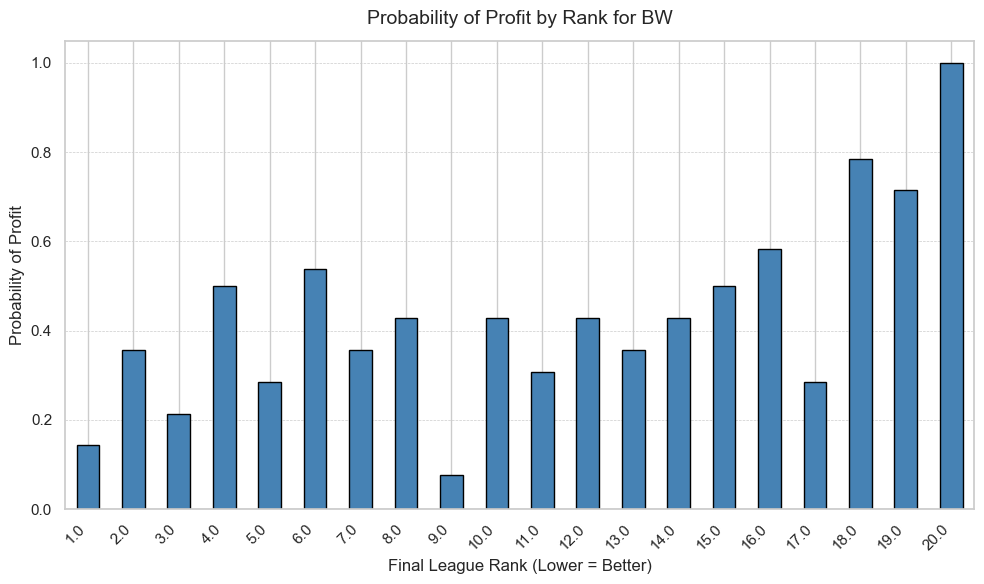

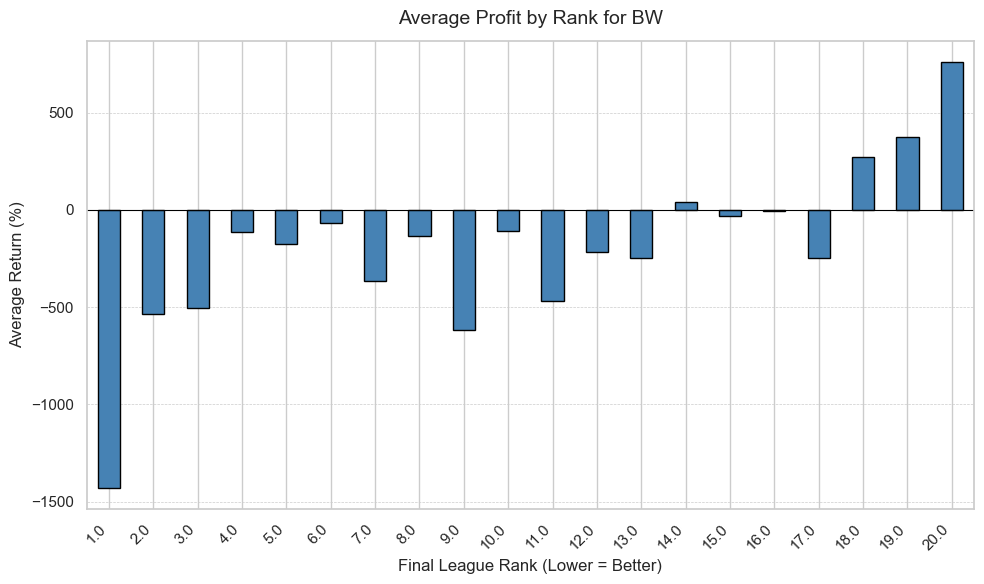

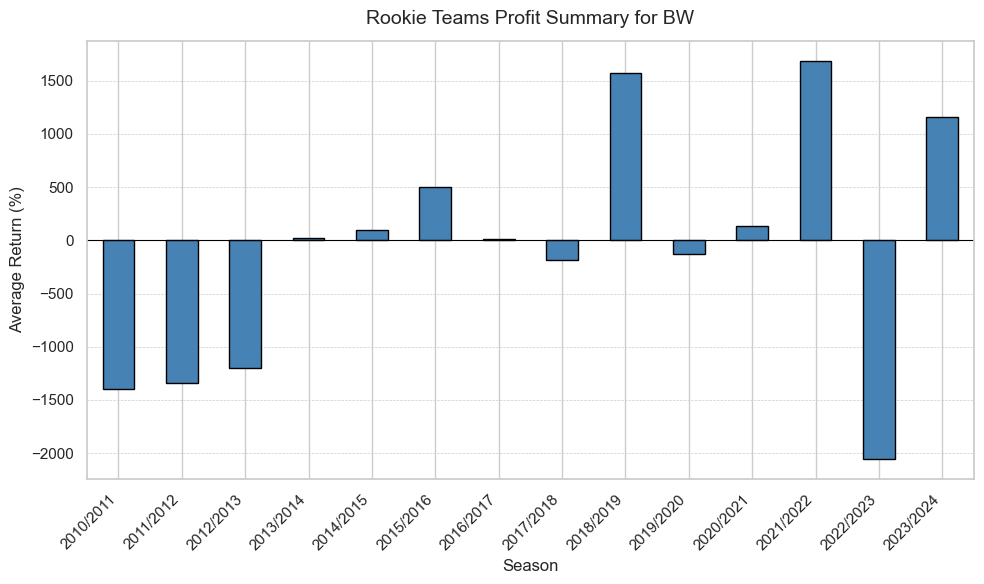

Average Rookie Teams Profit for BW: -80.36 %
Average Profit for BW from relegating teams: 468.1 %
--------------------------------------------------

CL
Missing odds columns for bookie CL in PL_data/10-11.csv
Missing odds columns for bookie CL in PL_data/11-12.csv
Missing odds columns for bookie CL in PL_data/12-13.csv
Missing odds columns for bookie CL in PL_data/13-14.csv
Missing odds columns for bookie CL in PL_data/14-15.csv
Missing odds columns for bookie CL in PL_data/15-16.csv
Missing odds columns for bookie CL in PL_data/16-17.csv
Missing odds columns for bookie CL in PL_data/17-18.csv
Missing odds columns for bookie CL in PL_data/18-19.csv
Missing odds columns for bookie CL in PL_data/19-20.csv
Missing odds columns for bookie CL in PL_data/20-21.csv
Missing odds columns for bookie CL in PL_data/21-22.csv
Missing odds columns for bookie CL in PL_data/22-23.csv
Missing odds columns for bookie CL in PL_data/23-24.csv
GB
Missing odds columns for bookie GB in PL_data/13-14.csv
Miss

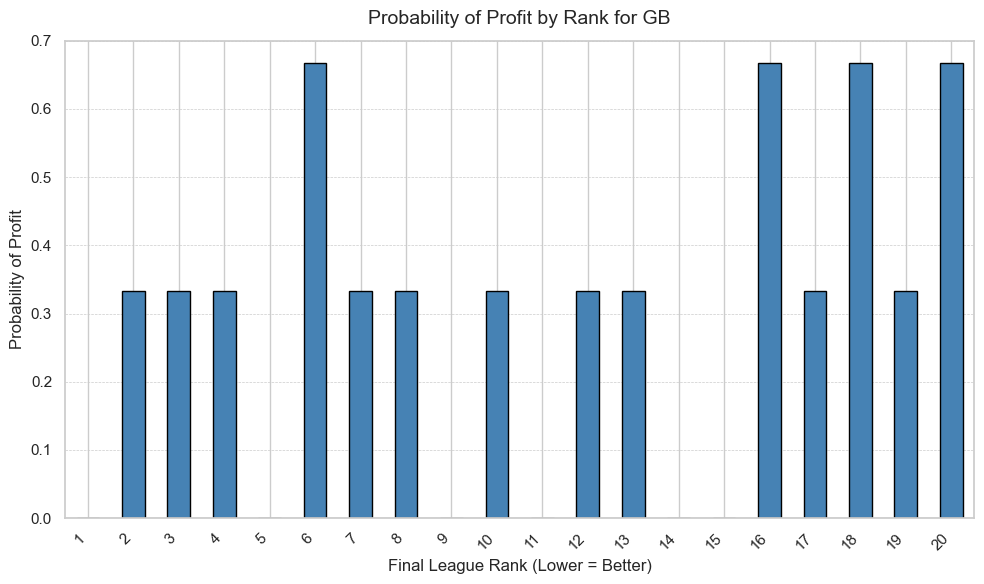

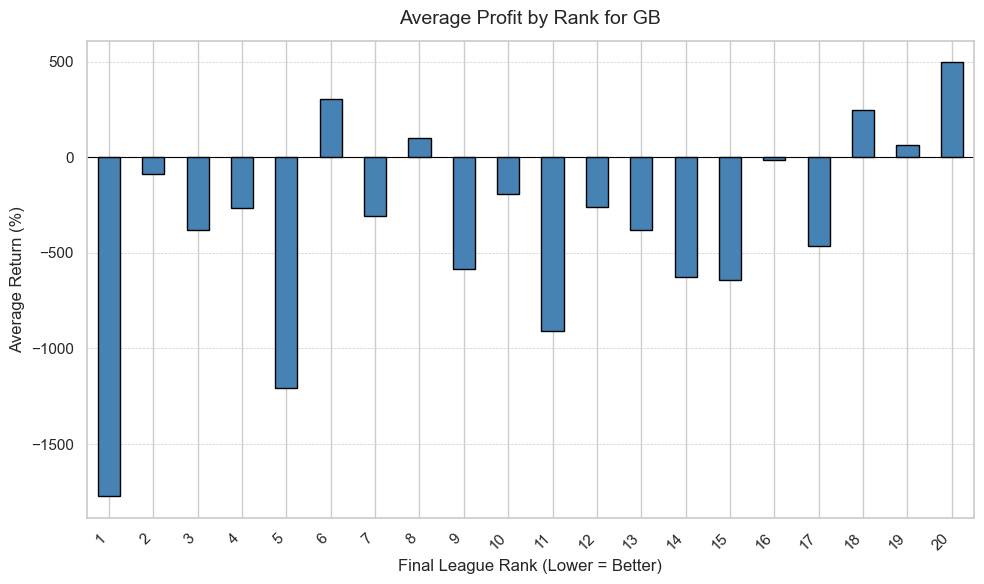

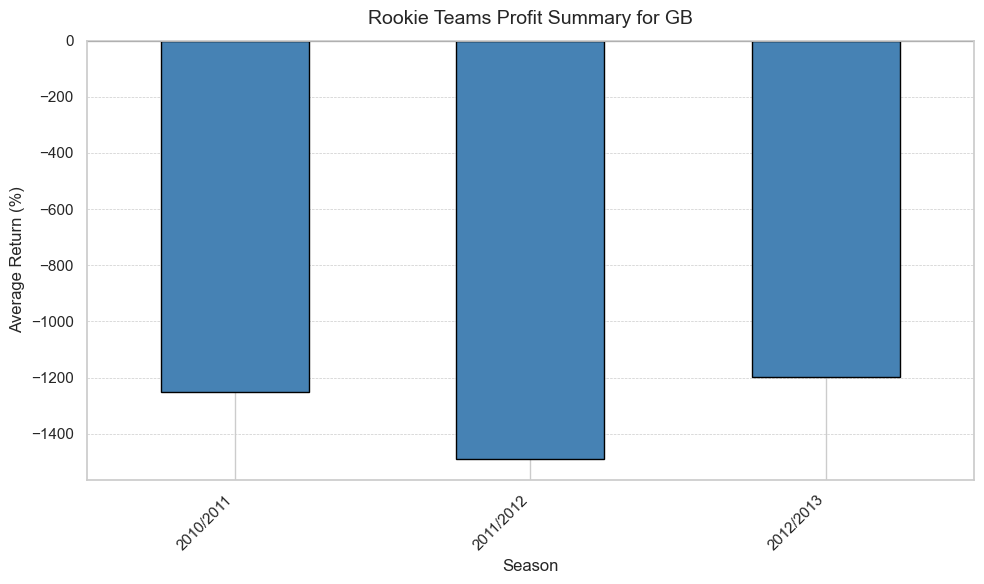

Average Rookie Teams Profit for GB: -1312.67 %
Average Profit for GB from relegating teams: 240.75 %
--------------------------------------------------

IW


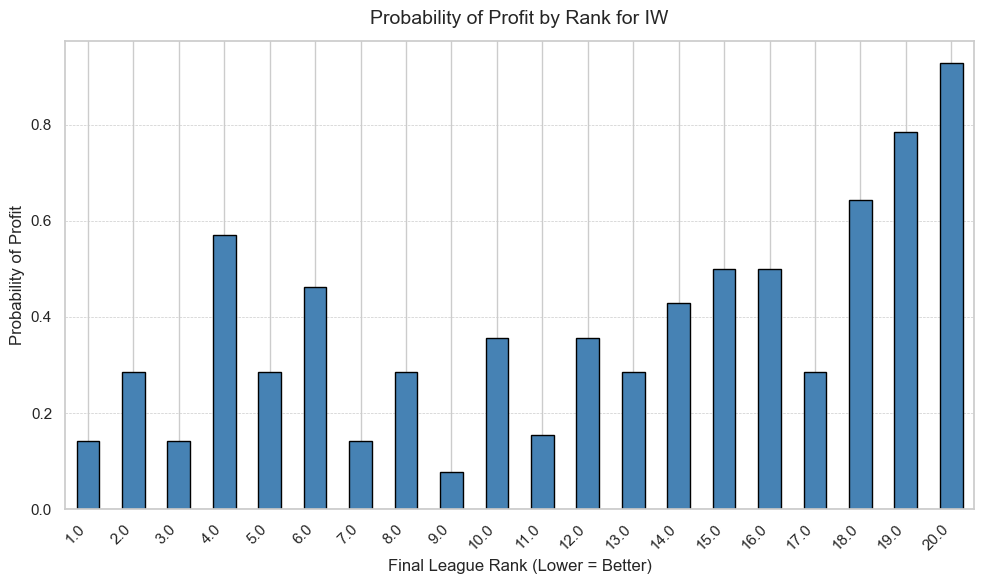

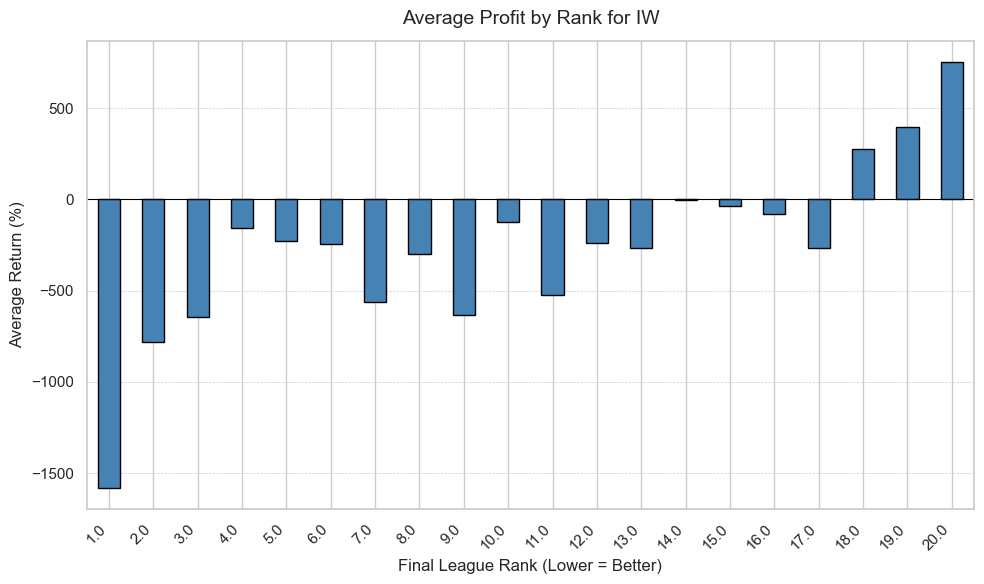

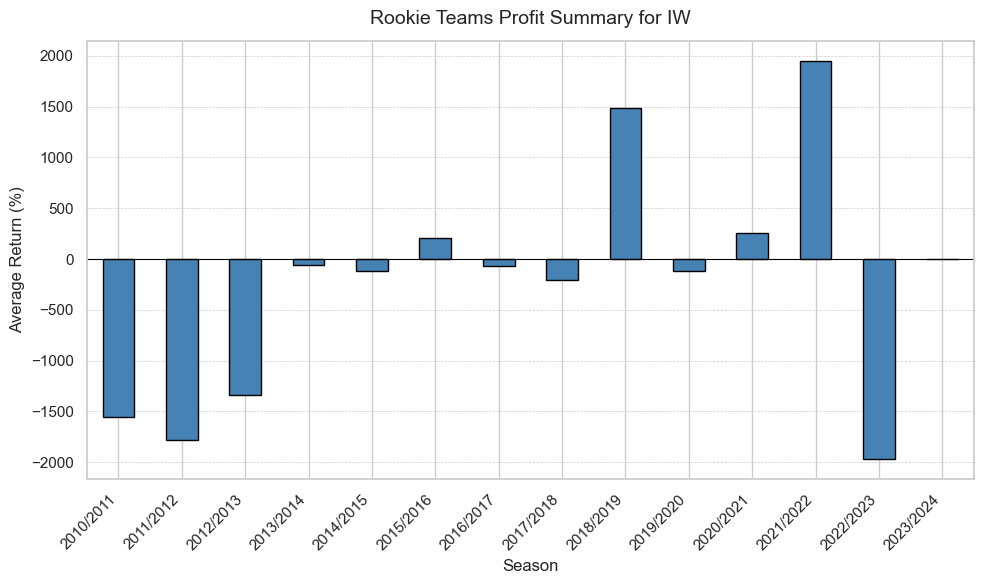

Average Rookie Teams Profit for IW: -237.36 %
Average Profit for IW from relegating teams: 481.26 %
--------------------------------------------------

LB
Missing odds columns for bookie LB in PL_data/18-19.csv
Missing odds columns for bookie LB in PL_data/19-20.csv
Missing odds columns for bookie LB in PL_data/20-21.csv
Missing odds columns for bookie LB in PL_data/21-22.csv
Missing odds columns for bookie LB in PL_data/22-23.csv
Missing odds columns for bookie LB in PL_data/23-24.csv


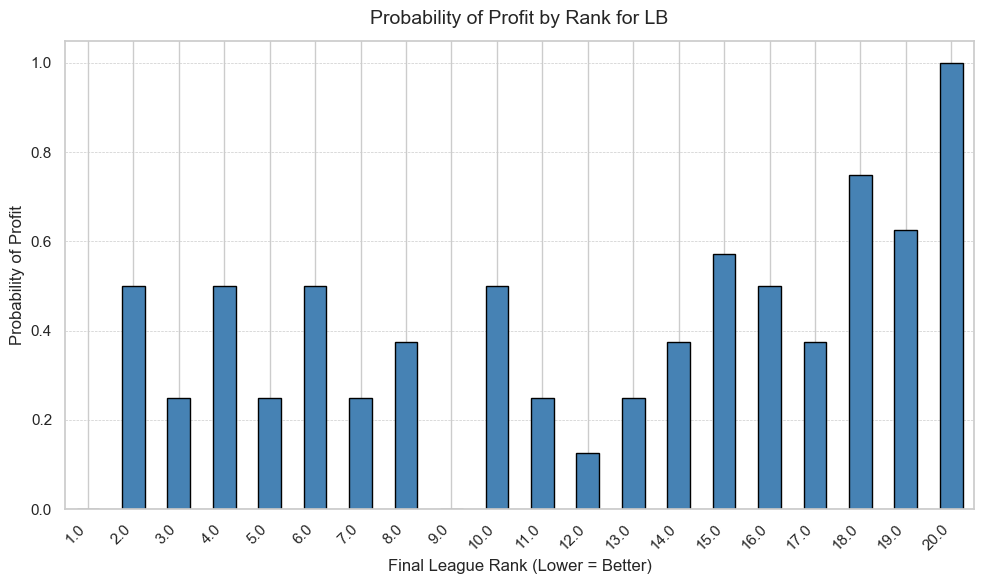

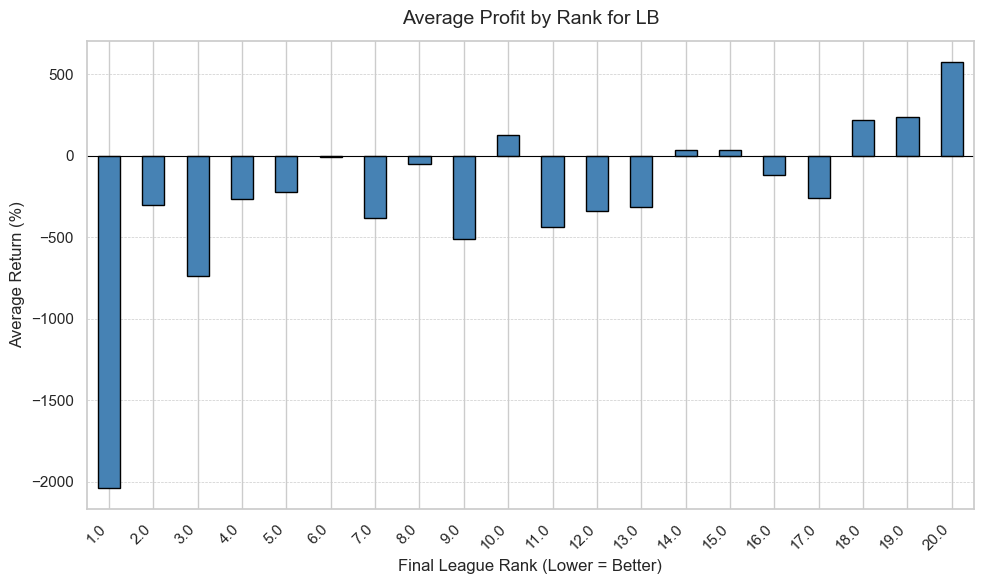

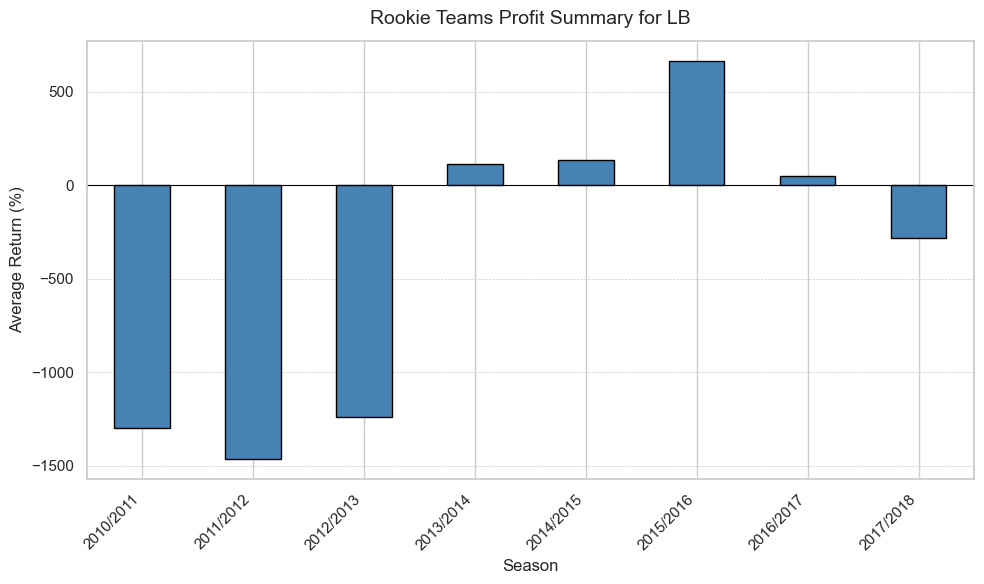

Average Rookie Teams Profit for LB: -414.0 %
Average Profit for LB from relegating teams: 344.25 %
--------------------------------------------------

PSH/PH
Missing odds columns for bookie PSH/PH in PL_data/10-11.csv
Missing odds columns for bookie PSH/PH in PL_data/11-12.csv
Missing odds columns for bookie PSH/PH in PL_data/12-13.csv
Missing odds columns for bookie PSH/PH in PL_data/13-14.csv
Missing odds columns for bookie PSH/PH in PL_data/14-15.csv
Missing odds columns for bookie PSH/PH in PL_data/15-16.csv
Missing odds columns for bookie PSH/PH in PL_data/16-17.csv
Missing odds columns for bookie PSH/PH in PL_data/17-18.csv
Missing odds columns for bookie PSH/PH in PL_data/18-19.csv
Missing odds columns for bookie PSH/PH in PL_data/19-20.csv
Missing odds columns for bookie PSH/PH in PL_data/20-21.csv
Missing odds columns for bookie PSH/PH in PL_data/21-22.csv
Missing odds columns for bookie PSH/PH in PL_data/22-23.csv
Missing odds columns for bookie PSH/PH in PL_data/23-24.csv
PS

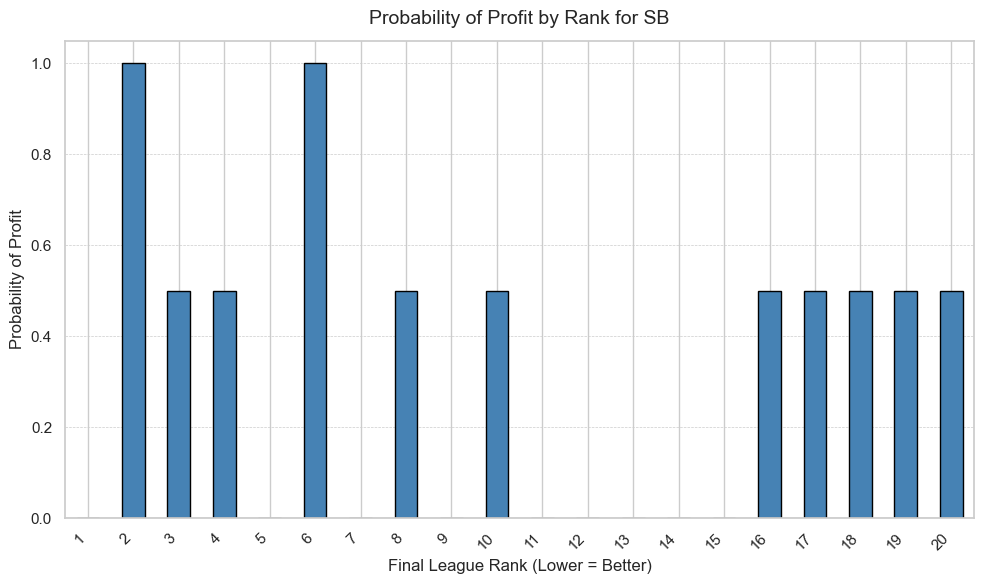

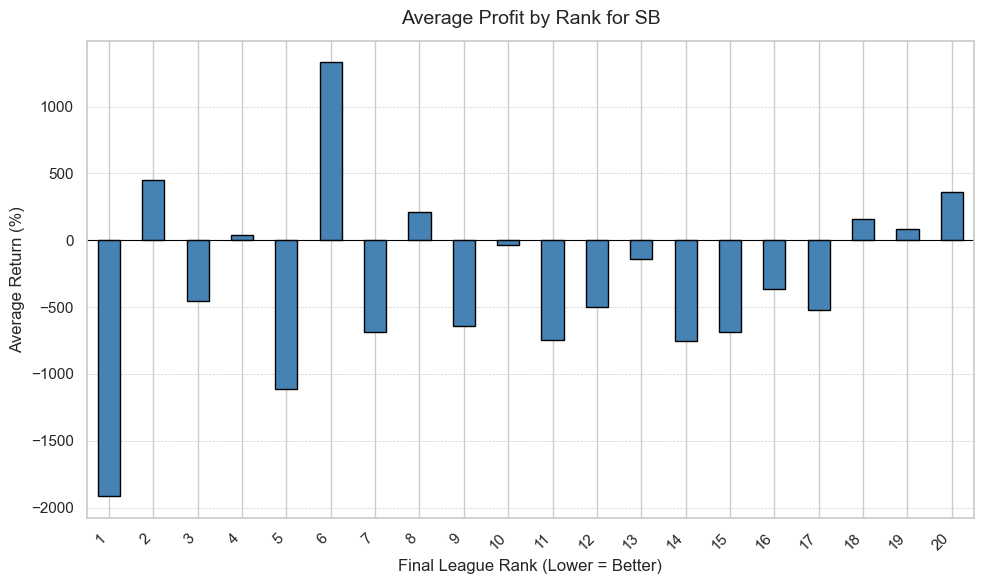

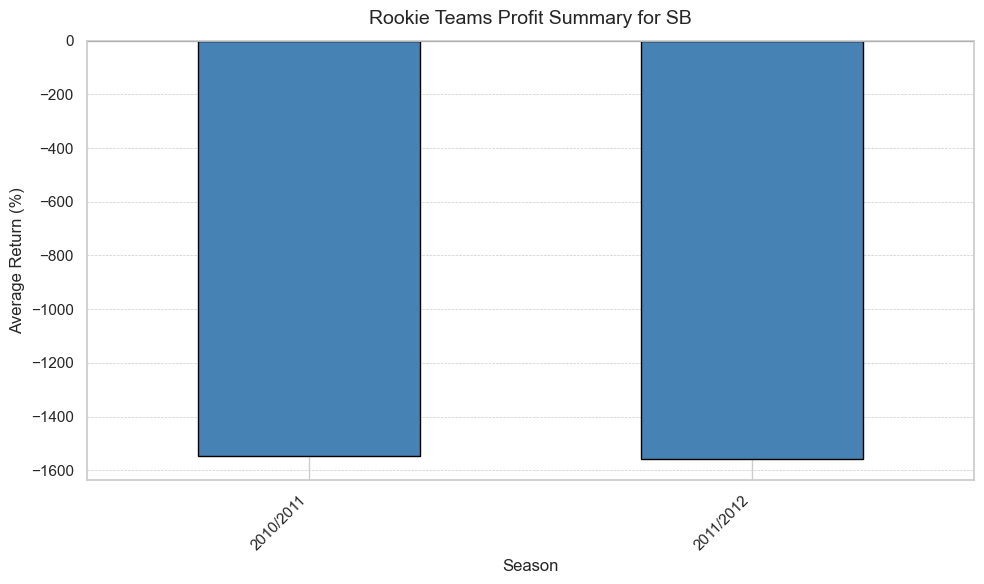

Average Rookie Teams Profit for SB: -1552.65 %
Average Profit for SB from relegating teams: 201.45 %
--------------------------------------------------

SJ
Missing odds columns for bookie SJ in PL_data/15-16.csv
Missing odds columns for bookie SJ in PL_data/16-17.csv
Missing odds columns for bookie SJ in PL_data/17-18.csv
Missing odds columns for bookie SJ in PL_data/18-19.csv
Missing odds columns for bookie SJ in PL_data/19-20.csv
Missing odds columns for bookie SJ in PL_data/20-21.csv
Missing odds columns for bookie SJ in PL_data/21-22.csv
Missing odds columns for bookie SJ in PL_data/22-23.csv
Missing odds columns for bookie SJ in PL_data/23-24.csv


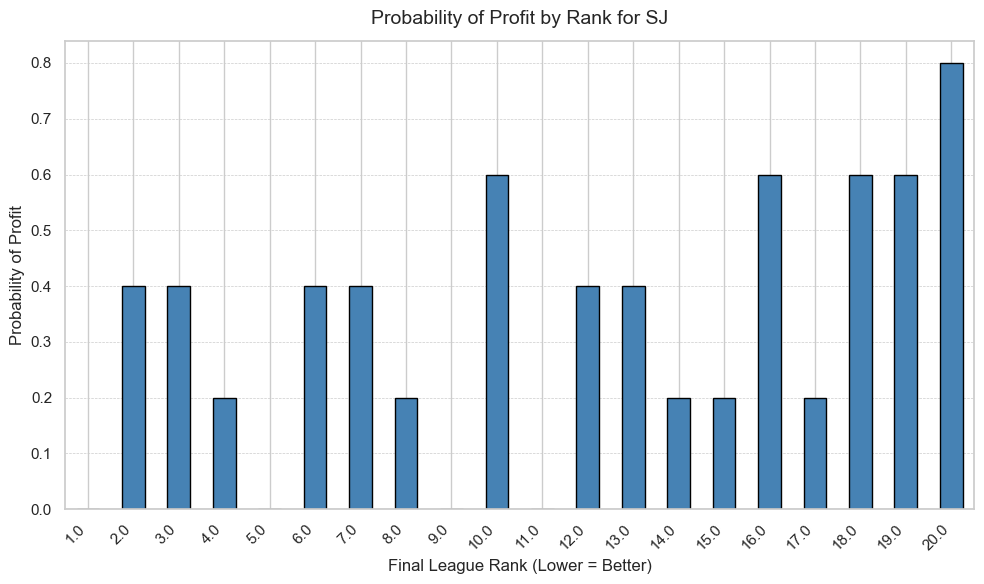

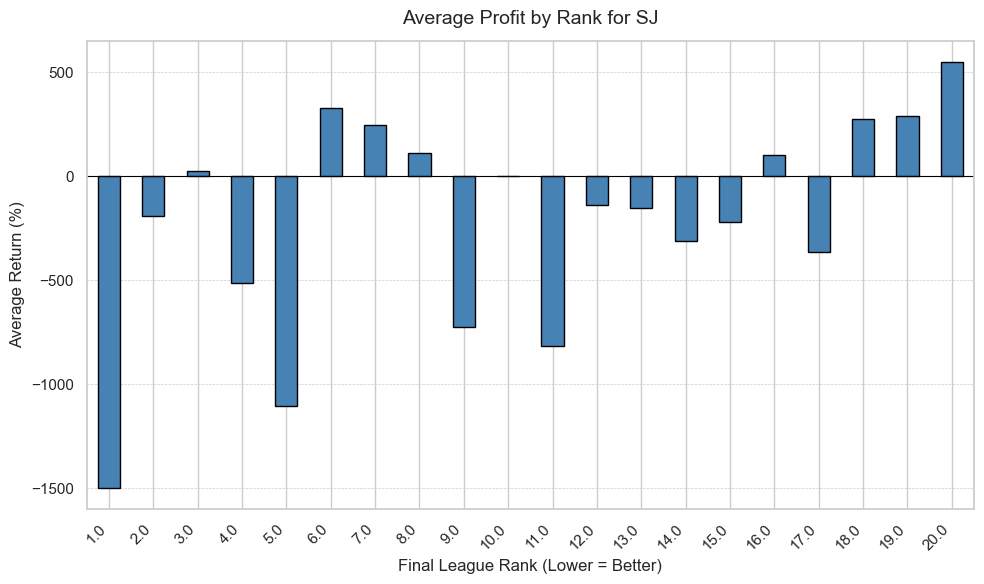

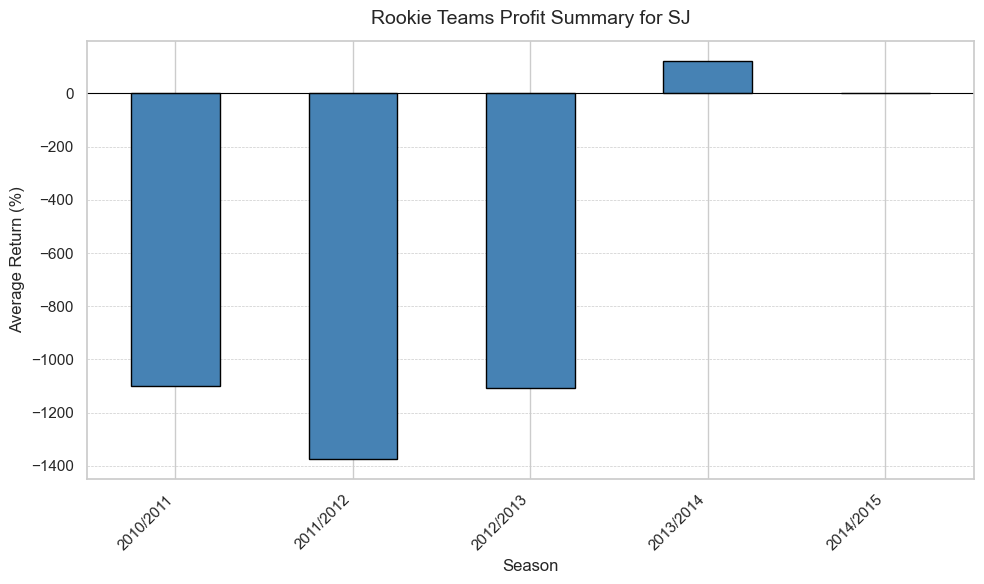

Average Rookie Teams Profit for SJ: -692.2 %
Average Profit for SJ from relegating teams: 370.67 %
--------------------------------------------------

SY
Missing odds columns for bookie SY in PL_data/10-11.csv
Missing odds columns for bookie SY in PL_data/11-12.csv
Missing odds columns for bookie SY in PL_data/12-13.csv
Missing odds columns for bookie SY in PL_data/13-14.csv
Missing odds columns for bookie SY in PL_data/14-15.csv
Missing odds columns for bookie SY in PL_data/15-16.csv
Missing odds columns for bookie SY in PL_data/16-17.csv
Missing odds columns for bookie SY in PL_data/17-18.csv
Missing odds columns for bookie SY in PL_data/18-19.csv
Missing odds columns for bookie SY in PL_data/19-20.csv
Missing odds columns for bookie SY in PL_data/20-21.csv
Missing odds columns for bookie SY in PL_data/21-22.csv
Missing odds columns for bookie SY in PL_data/22-23.csv
Missing odds columns for bookie SY in PL_data/23-24.csv
VC


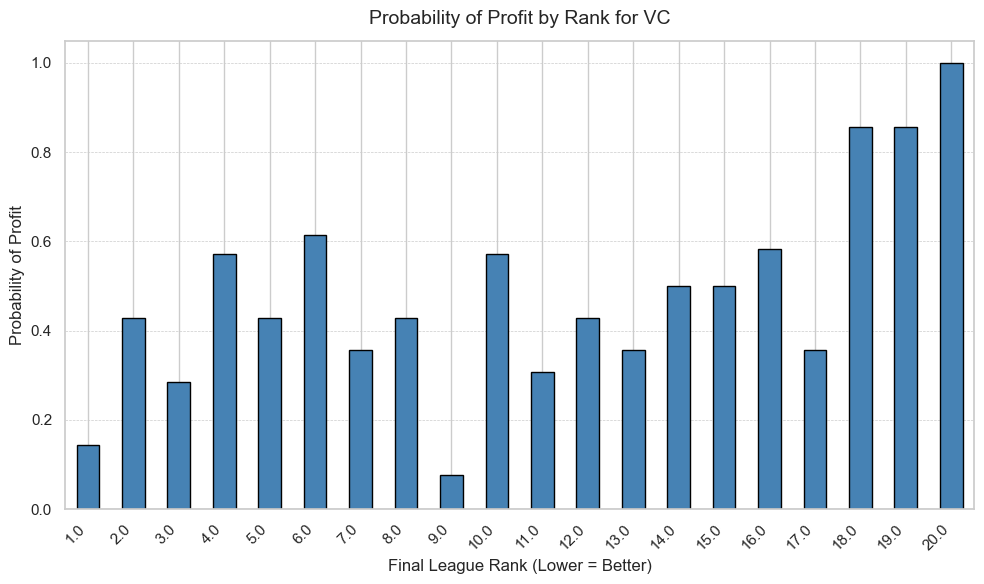

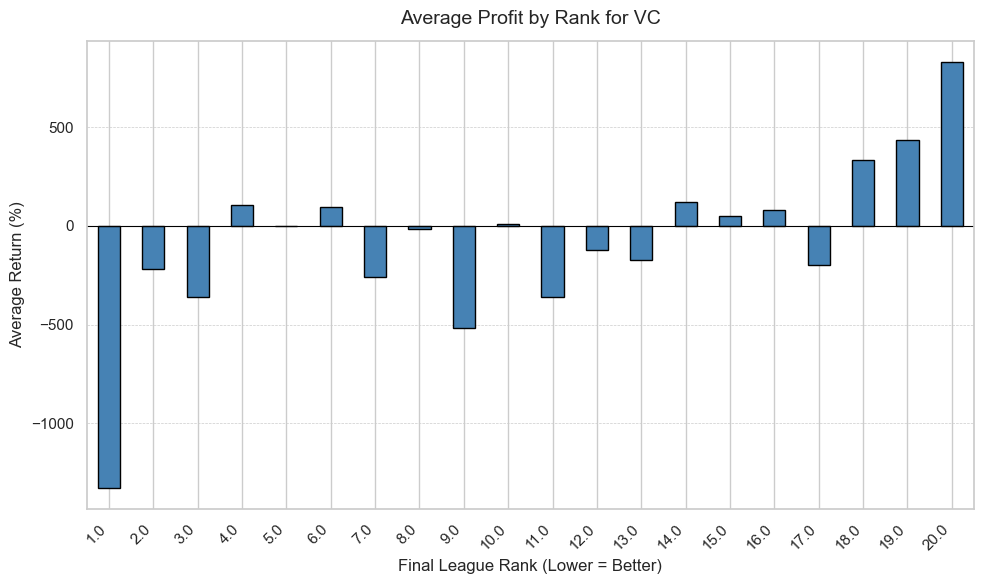

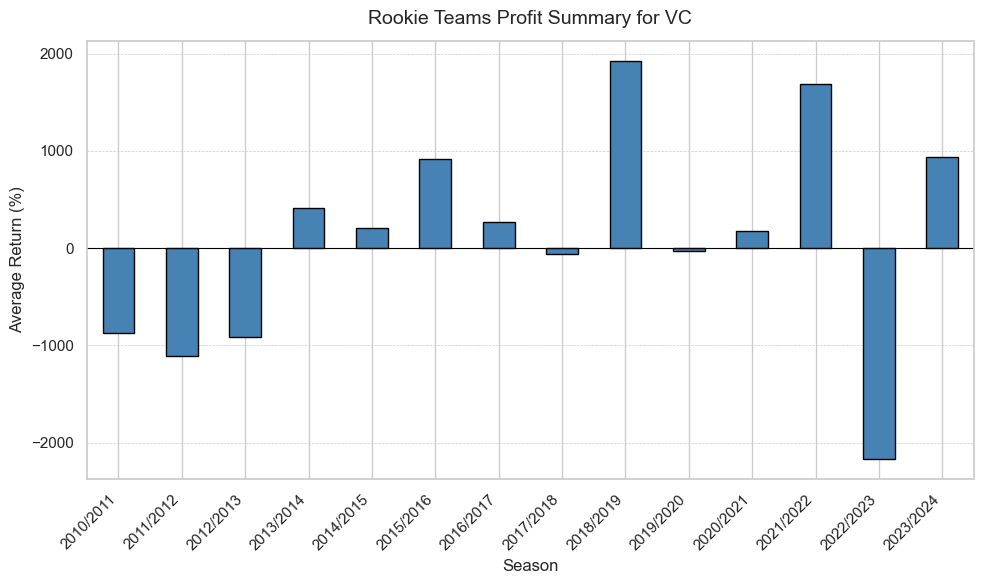

Average Rookie Teams Profit for VC: 100.37 %
Average Profit for VC from relegating teams: 533.23 %
--------------------------------------------------

WH


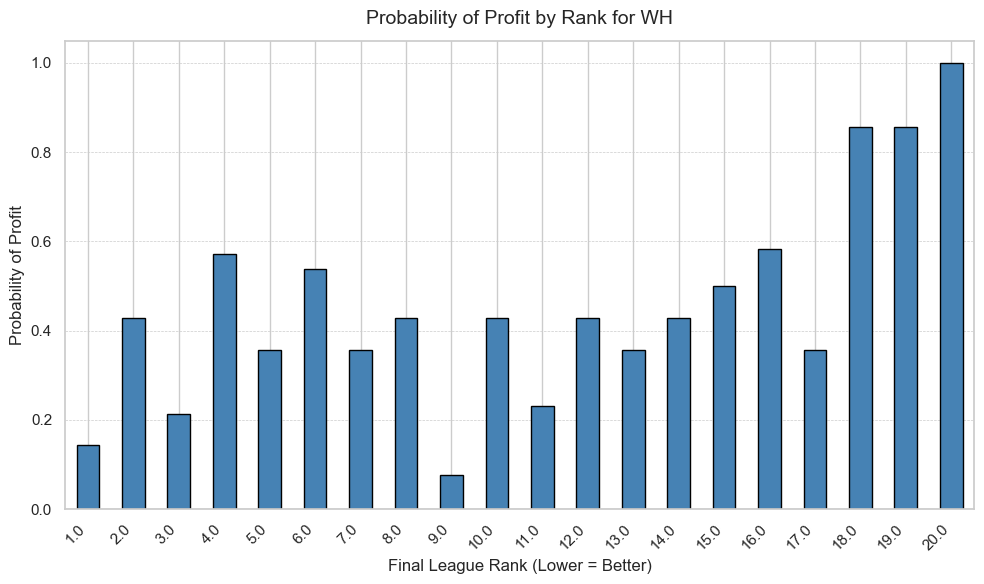

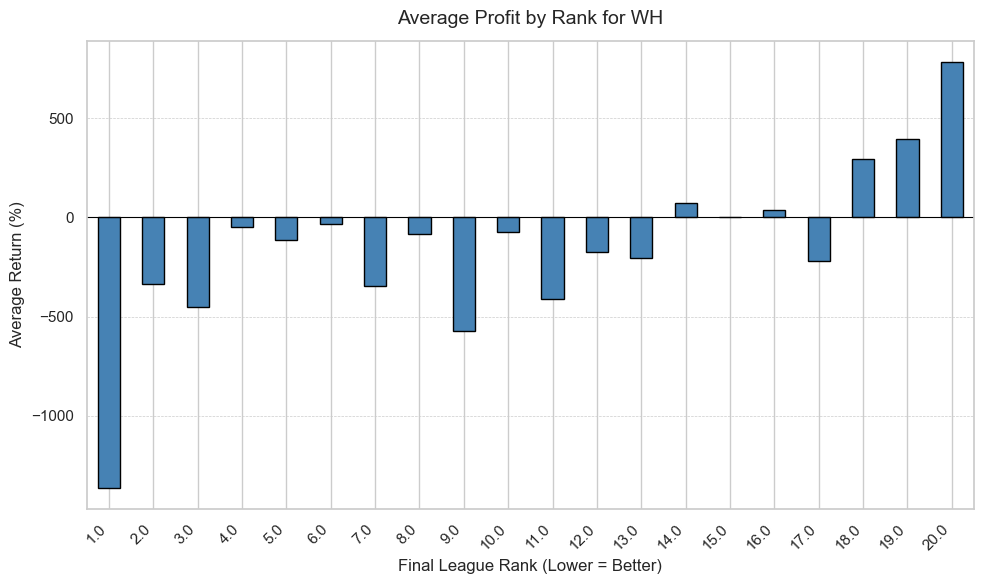

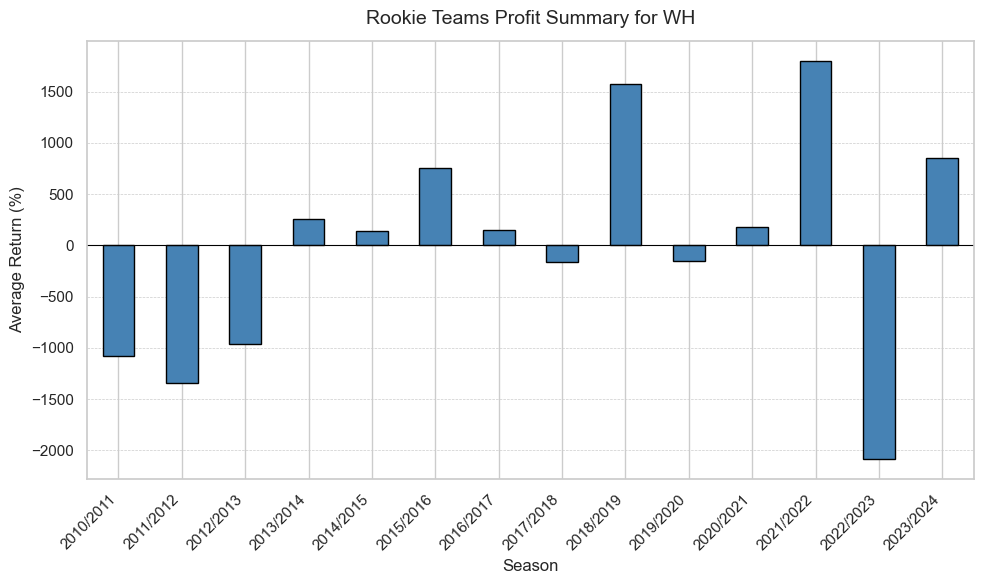

Average Rookie Teams Profit for WH: -5.07 %
Average Profit for WH from relegating teams: 490.74 %
--------------------------------------------------



In [16]:
# List of PL season data files
dfs = [f'PL_data/{i}-{i+1}.csv' for i in range(10, 24)]


# Run analysis
for bookie in unique_bookmakers:
    print(bookie)
    final_df = pd.DataFrame()
    for df_name in dfs:
        temp_df = calculate_anti_team_betting_profits(df_name, bookie=bookie, ranks_df=pl_rank)
        if temp_df is not None:
            final_df = pd.concat([final_df, temp_df], ignore_index=True)
    if 'Profit' in final_df.columns:
        final_df['Profit'] = final_df['Profit'] * 100  # Convert to percentage
        final_df['P/L'] = final_df['Profit'] > 0
        probability_of_profit = final_df.groupby('Rank')['P/L'].mean()
        avg_profit = final_df.groupby('Rank')['Profit'].mean()

        plot(probability_of_profit, 
              title=f'Probability of Profit by Rank for {bookie}',
              x='Final League Rank (Lower = Better)', y='Probability of Profit')
        plot(avg_profit, title=f'Average Profit by Rank for {bookie}',
              x='Final League Rank (Lower = Better)', y='Average Return (%)')

        rookies_df = final_df[final_df.apply(is_rookie, axis=1)]
        rookie_summary = rookies_df.groupby(['Season'])['Profit'].sum()
        plot(rookie_summary, 
              title=f'Rookie Teams Profit Summary for {bookie}',
              x='Season', y='Average Return (%)')
        
        print(f'Average Rookie Teams Profit for {bookie}: {round(rookie_summary.mean(),2)} %')
        print(f'Average Profit for {bookie} from relegating teams: {round(final_df[final_df['Rank'] > 17]["Profit"].mean(),2)} %')
        print(50* '-')
        print()